# Optimization and Simulation with DR

## hyperoptによるアプローチ

### 1. ライブラリ類のインポートとファイルのロード

In [ ]:
!pip install datarobot
!git clone https://github.com/nejumi/opt_workshop.git

In [1]:
import os
import requests
import sys
import io

import numpy as np
seed = 71
np.random.seed(seed)

import pandas as pd
from pandas import DataFrame, Series
from pandas.io.json import json_normalize

from sklearn.externals import joblib

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'figure.max_open_warning': 0})

%matplotlib inline
%matplotlib nbagg

from hyperopt import fmin, tpe, hp, rand, Trials
from hyperopt.pyll import scope, stochastic

import datarobot as dr

In [2]:
df = pd.read_csv('./input/concrete.csv')

In [3]:
y_train = df['コンクリート圧縮強度(Mpa)']
X_train = df.drop(['コンクリート圧縮強度(Mpa)'], axis=1)

### 2. 予測APIを用いる上での必要な情報を準備しておきます。

In [4]:
# 予測APIを叩くための諸々を設定する必要があります
API_TOKEN = 'your_api_key_here'
USERNAME = 'your_user_name_here'
PRED_SERVER = 'https://your.pred.server.com/predApi/v1.0/'
KEY = 'your_dr_key_here'

# 使用するモデルのDEPLOYMENT_IDを指定する必要があります
DEPLOYMENT_ID = 'your_deployment_id_here'

MAX_WAIT = 60 * 60

### 3. 予測APIを叩いて結果を返す関数を作っておきます。

In [5]:
# DataRobotの予測APIを叩いて予測結果を引っ張る関数
# Using v1 is highly recommended


def get_prediction(df, API_TOKEN, USERNAME, KEY, DEPLOYMENT_ID, PRED_SERVER):

    headers = {'Content-Type': 'text/plain; charset=UTF-8',
               'datarobot-key': KEY}

    buffer = io.BytesIO()
    wrapper = io.TextIOWrapper(buffer, encoding='utf-8', write_through=True)
    df.to_csv(wrapper)

    predictions_response = requests.post(os.path.join(PRED_SERVER, 'predApi/v1.0/deployments/%s/predictions' % (DEPLOYMENT_ID)),
                                         auth=(USERNAME, API_TOKEN), data=buffer.getvalue(), headers=headers)

    if predictions_response.status_code != 200:
        try:
            message = predictions_response.json().get('message', predictions_response.text)
            status_code = predictions_response.status_code
            reason = predictions_response.reason

            print(u'Status: {status_code} {reason}. Message: {message}.'.format(message=message,
                                                                                status_code=status_code,
                                                                                reason=reason))
        except ValueError:
            print('Prediction failed: {}'.format(predictions_response.reason))
            predictions_response.raise_for_status()
    else:
        return json_normalize(predictions_response.json()['data']).prediction.values

### 試しに１回叩いてみましょう。

In [6]:
# 試しにAPIをたたいてみましょう
pred = get_prediction(X_train, API_TOKEN, USERNAME, KEY, DEPLOYMENT_ID, PRED_SERVER)

print(pred)

[ 14.63563339  23.32490712  67.3603261  ...,  51.27354112  54.63100895
  38.48030987]


### 4. 探索空間の設定を行います

In [7]:
# 最適化を行う際の候補となる特徴空間を先程の正規分布で指定します。

search_space = {}

for col in X_train.columns:

    norm_dist = hp.normal(col, X_train[col].mean(), X_train[col].std())
    min_value = X_train[col].min()
    max_value = X_train[col].max()

    search_space[col] = scope.minimum(scope.maximum(
        norm_dist, min_value * 0.8), max_value * 1.5)

### 5. 最適化する対象設定します。この関数の戻り値が最小化されるようにhyperoptが探索空間からいい感じの入力データを見つけてくれます。

In [8]:
# 最適化の対象。この関数の戻り値を最小化します。

count = 0
X_store = DataFrame()


def objective(search_space):
    global count, X_store

    df_target = DataFrame(index=[count], columns=X_train.columns)
    for col in X_train.columns:
        df_target[col] = search_space[col]

    pred = get_prediction(df_target, API_TOKEN, USERNAME, KEY, DEPLOYMENT_ID, PRED_SERVER)
    pred = pred[0]

    count = count + 1
    X_store = pd.concat([X_store, df_target], axis=0)

    print('Iteration %s, 予想コンクリート圧縮強度(Mpa): %.3f' % (count, pred))

    return -pred  # 今回は最大化したいので、符号を反転させておきます。

### 6. 最適化を実行します。

### fminに最小化したい関数と探索空間、適用するアルゴリズム、結果の保管先となるTrialsオブジェクト、乱数のシードを指定します。

In [9]:
%%time
# 最適化を開始します。

count = 0
num_iter = 150

trials = Trials()

best = fmin(objective,
            space=search_space,
            algo=tpe.suggest,
            max_evals=num_iter,
            trials=trials,
            rstate=np.random.RandomState(seed))

Iteration 1, 予想コンクリート圧縮強度(Mpa): 41.548
Iteration 2, 予想コンクリート圧縮強度(Mpa): 34.808
Iteration 3, 予想コンクリート圧縮強度(Mpa): 35.516
Iteration 4, 予想コンクリート圧縮強度(Mpa): 33.667
Iteration 5, 予想コンクリート圧縮強度(Mpa): 45.797
Iteration 6, 予想コンクリート圧縮強度(Mpa): 33.339
Iteration 7, 予想コンクリート圧縮強度(Mpa): 52.357
Iteration 8, 予想コンクリート圧縮強度(Mpa): 45.173
Iteration 9, 予想コンクリート圧縮強度(Mpa): 64.434
Iteration 10, 予想コンクリート圧縮強度(Mpa): 53.885
Iteration 11, 予想コンクリート圧縮強度(Mpa): 52.761
Iteration 12, 予想コンクリート圧縮強度(Mpa): 45.903
Iteration 13, 予想コンクリート圧縮強度(Mpa): 6.051
Iteration 14, 予想コンクリート圧縮強度(Mpa): 40.028
Iteration 15, 予想コンクリート圧縮強度(Mpa): 44.219
Iteration 16, 予想コンクリート圧縮強度(Mpa): 10.042
Iteration 17, 予想コンクリート圧縮強度(Mpa): 46.593
Iteration 18, 予想コンクリート圧縮強度(Mpa): 57.300
Iteration 19, 予想コンクリート圧縮強度(Mpa): 37.502
Iteration 20, 予想コンクリート圧縮強度(Mpa): 52.794
Iteration 21, 予想コンクリート圧縮強度(Mpa): 68.567
Iteration 22, 予想コンクリート圧縮強度(Mpa): 69.075
Iteration 23, 予想コンクリート圧縮強度(Mpa): 68.287
Iteration 24, 予想コンクリート圧縮強度(Mpa): 62.518
Iteration 25, 予想コンクリート圧縮強度(Mpa): 70.828
Iteration 

In [10]:
y_store = -np.array(trials.losses())

In [11]:
# 今回の探索で得られた最適な変数の組み合わせとその時の予測強度
print(X_store.iloc[np.argmax(y_store)])
print('\n')
print('予想コンクリート強度: ', y_store.max())

単位セメント量(kg in m^3)        600.530660
高炉スラグ分量(kg in m^3)        378.402267
フライアッシュ分量(kg in m^3)        0.000000
単位水量(kg in m^3)           143.266175
高性能AE減水剤分量(kg in m^3)       0.000000
粗骨材分量(kg in m^3)         1715.515690
細骨材分量(kg in m^3)          665.291798
材齢(日)                     182.270252
Name: 86, dtype: float64


予想コンクリート強度:  94.1902478267


### 7. 探索過程をgif動画にしてみてみましょう

<IPython.core.display.Javascript object>


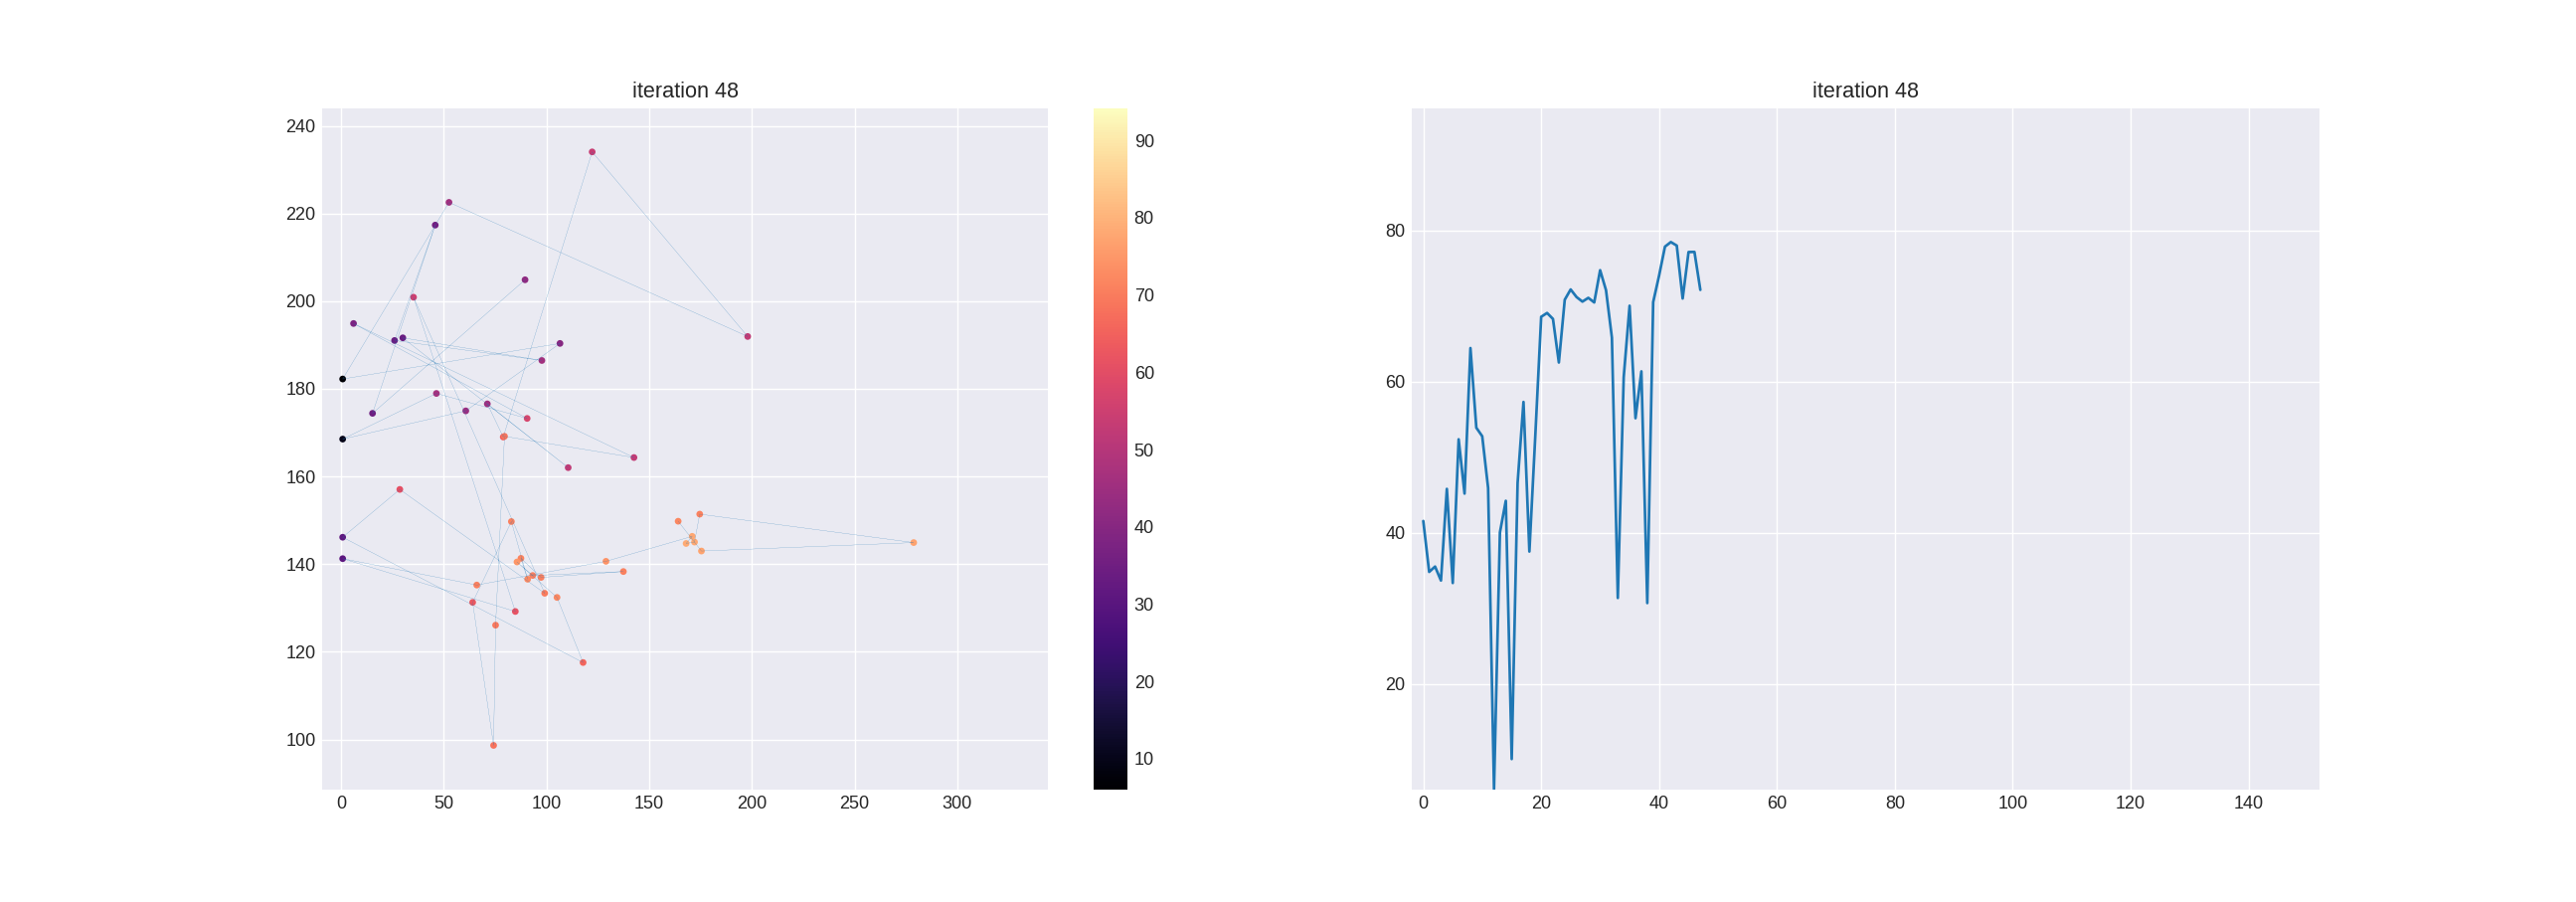

In [12]:
# 探索の過程を可視化してみましょう
def update(i, feature_1, feature_2):
    plt.clf()

    plt.subplot(1, 2, 1)
    plt.scatter(X_store[feature_1].iloc[:i], X_store[feature_2].iloc[:i], s=7.5,
                c=y_store[:i], cmap=cm.magma, vmin=y_store.min(), vmax=y_store.max())
    plt.plot(X_store[feature_1].iloc[:i],
             X_store[feature_2].iloc[:i], linewidth=0.1)
    plt.xlim(X_store[feature_1].min() - 10, X_store[feature_1].max() + 10)
    plt.ylim(X_store[feature_2].min() - 10, X_store[feature_2].max() + 10)
    plt.clim(y_store.min(), y_store.max())
    plt.colorbar()
    plt.title('iteration ' + str(i))

    plt.subplot(1, 2, 2)
    plt.plot(list(range(len(y_store[:i]))), y_store[:i])
    plt.xlim(-2, len(y_store) + 2)
    plt.ylim(y_store.min(-1), y_store.max() + 2)
    plt.title('iteration ' + str(i))


fig = plt.figure(figsize=(20, 7))
ani = animation.FuncAnimation(fig, update, fargs=(
    '材齢(日)', '単位水量(kg in m^3)'), interval=100, frames=num_iter)

#ani.save("./output/hyperopt_animation.gif", writer="imagemagick")
plt.show()

In [ ]:
# This is the end of this code...